## Exploratory Data Analysis

In [17]:
# Import The Libraries
import pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy as sp, warnings
warnings.filterwarnings("ignore")

In [18]:
retail_dataset=pd.read_excel('online_retail_II.xlsx',sheet_name=None)
retail_data_Clean = retail_dataset['Year 2009-2010'].append(retail_dataset['Year 2010-2011'],ignore_index=True)
#check for missing values
(retail_data_Clean.isna().sum()/retail_data_Clean.shape[0])*100

Invoice         0.000000
StockCode       0.000000
Description     0.410541
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.766873
Country         0.000000
dtype: float64

In [19]:
#remove all customers with NA customer ID
retail_data_Clean = retail_data_Clean[retail_data_Clean['Customer ID'].notna()]
#check for missing values
(retail_data_Clean.isna().sum()/retail_data_Clean.shape[0])*100

Invoice        0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
Price          0.0
Customer ID    0.0
Country        0.0
dtype: float64

### Plots

In [20]:
sns.set_style('whitegrid')
print('Quantity negative count',retail_data_Clean[(retail_data_Clean['Quantity'] < 0)].shape[0]/retail_data_Clean.shape[0])
print('Price zero count',retail_data_Clean[(retail_data_Clean['Price'] == 0)].shape[0]/retail_data_Clean.shape[0])

print("Number of duplicated transactions:", len(retail_data_Clean[retail_data_Clean.duplicated()])/retail_data_Clean.shape[0])

#remove the negative quantity values and duplicate transactions
retail_data = retail_data_Clean[(retail_data_Clean['Price'] > 0) & (retail_data_Clean['Quantity']>0)]
retail_data.drop_duplicates(inplace = True)
retail_data['Final_Price'] = retail_data['Price'] * retail_data['Quantity']

Quantity negative count 0.022737528567477475
Price zero count 8.612700214953589e-05
Number of duplicated transactions: 0.03212051957630367


In [21]:
#Adding features as year, month, month_year, day of week, hour:
retail_data['month'] = retail_data['InvoiceDate'].dt.month
retail_data['year'] = retail_data['InvoiceDate'].dt.year
retail_data['weekday'] = retail_data['InvoiceDate'].dt.day_name()
retail_data['m_y'] = pd.to_datetime(retail_data[['year', 'month']].assign(Day=1))

### Plots of Invoice vs Date

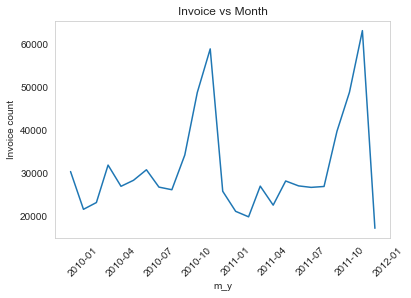

In [22]:
#Plot 1 : Count of Invoice per month
plot1 = pd.DataFrame(retail_data.groupby(['m_y'])['Invoice'].count()).reset_index()
ax = sns.lineplot(x="m_y", y="Invoice",data = plot1)
plt.xticks(rotation=45)
plt.grid(False)
plt.title('Invoice vs Month')
plt.ylabel('Invoice count')
plt.show()

Text(0, 0.5, 'Invoice count')

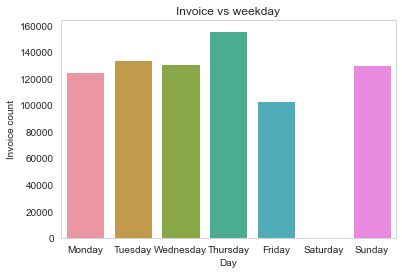

In [29]:
#Plot 2: Count of Invoice per day
plot2 = pd.DataFrame(retail_data.groupby(['weekday'])['Invoice'].count())
plot2 = plot2.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']).reset_index()
sns.set_palette("husl")
ax = sns.barplot(x="weekday", y="Invoice", data = plot2)
plt.grid(False)
plt.title('Invoice vs weekday')
plt.xlabel('Day')
plt.ylabel('Invoice count')

### Plots of Revenue vs Date

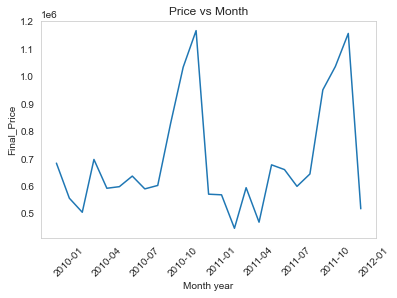

In [23]:
plot3 = pd.DataFrame(retail_data.groupby(['m_y'])['Final_Price'].sum()).reset_index()
#The highest sales are also during the November, as the number of purchasing is the highest.
ax = sns.lineplot(x = 'm_y', y='Final_Price', data = plot3)
plt.xticks(rotation=45)
plt.grid(False)
plt.title('Price vs Month')
plt.xlabel('Month year')
plt.ylabel('Final_Price')
plt.show()

In [24]:
(retail_data['Country'].value_counts()/retail_data.shape[0]).head()

United Kingdom    0.898596
Germany           0.021082
EIRE              0.019970
France            0.017335
Netherlands       0.006524
Name: Country, dtype: float64

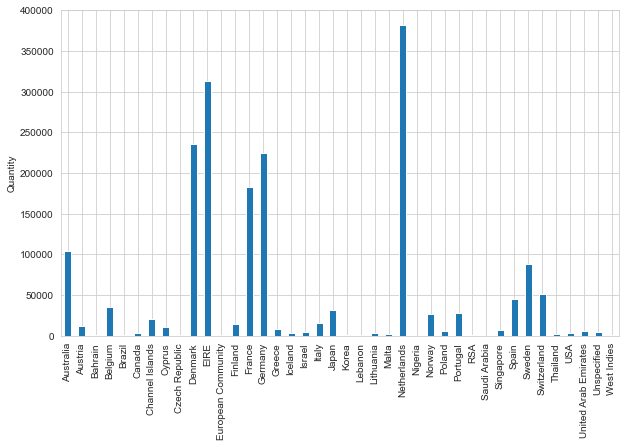

In [25]:
#removing UK as it accounts for 90% of the retail_data
retail_data_Country = retail_data_Clean[(retail_data_Clean.Country != 'United Kingdom')].groupby('Country')['Quantity'].sum()

fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
retail_data_Country.plot(kind='bar', ax=ax1).set(ylabel = 'Quantity',xlabel='')
plt.show()

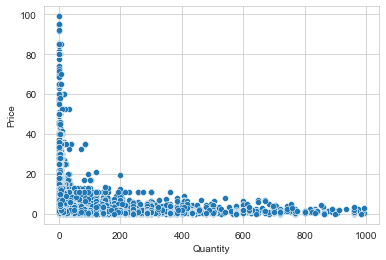

In [27]:
retail_data2 = retail_data[(retail_data['Quantity'] < 1000) & (retail_data['Price']<100)]

#plotting the qunatity vs price
Corr = sns.scatterplot(x="Quantity", y="Price", data = retail_data2)
plt.show()

### RFM Analysis

In [30]:
retail_data['date']= pd.to_datetime(retail_data['InvoiceDate'])
max_date=retail_data['date'].max()

In [37]:
retail_data_rfm=retail_data.groupby(['Customer ID']).agg({'Invoice':'nunique', 
                                            'InvoiceDate':'count',
                                                         'Final_Price':'sum',
                                                         'date':['min','max']})
retail_data_rfm.columns=['count','Frequency','total_cost','min_date','max_date']
retail_data_rfm.head()

,count,Frequency,total_cost,min_date,max_date
Customer ID,,,,,
12346.0,12,34,77556.46,2009-12-14 08:34:00,2011-01-18 10:01:00
12347.0,8,222,4921.53,2010-10-31 14:20:00,2011-12-07 15:52:00
12348.0,5,51,2019.40,2010-09-27 14:59:00,2011-09-25 13:13:00
12349.0,4,175,4428.69,2010-04-29 13:20:00,2011-11-21 09:51:00
12350.0,1,17,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00


In [38]:
#calculate recency
retail_data_rfm['Recency']=max_date-retail_data_rfm['max_date']
retail_data_rfm['Recency'] = retail_data_rfm['Recency'].dt.days

#calculate Monetary
retail_data_rfm['Monetary_value']=retail_data_rfm['total_cost']/retail_data_rfm['count']
retail_data_rfm=retail_data_rfm.drop(['count','total_cost','min_date','max_date'],axis=1)
retail_data_rfm.head()

,Frequency,Recency,Monetary_value
Customer ID,,,
12346.0,34,325,6463.038333
12347.0,222,1,615.191250
12348.0,51,74,403.880000
12349.0,175,18,1107.172500
12350.0,17,309,334.400000


In [39]:
#4 being the most recent
recency_grps = pd.qcut(retail_data_rfm.Recency, 4,[4,3,2,1])

#4 is the most frequent
freq_grps = pd.qcut(retail_data_rfm.Frequency, 4,[1,2,3,4])

#4 is the high monetary value
mon_grps = pd.qcut(retail_data_rfm.Monetary_value, 4,[1,2,3,4])
#Therefore, customers with R1, F4 and M4 are the best customers

In [40]:
# make a new column for group labels
retail_data_rfm['R'] = recency_grps.values
retail_data_rfm['F'] = freq_grps.values
retail_data_rfm['M'] = mon_grps.values
# sum up the three columns
retail_data_rfm['RFM_Score'] = retail_data_rfm[['R', 'F', 'M']].sum(axis = 1)

retail_data_rfm.head()

,Frequency,Recency,Monetary_value,R,F,M,RFM_Score
Customer ID,,,,,,,
12346.0,34,325,6463.038333,2,2,4,8
12347.0,222,1,615.191250,4,4,4,12
12348.0,51,74,403.880000,3,2,3,8
12349.0,175,18,1107.172500,4,4,4,12
12350.0,17,309,334.400000,2,1,3,6


Text(0, 0.5, 'Count')

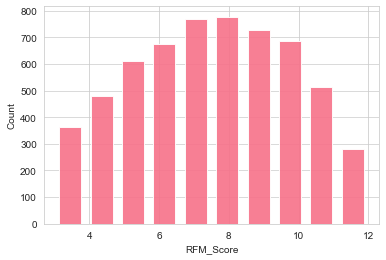

In [51]:
plt.hist(x=retail_data_rfm.RFM_Score,alpha=0.9,rwidth=0.70)
plt.grid(axis='y', alpha=0.9)
plt.xlabel('RFM_Score')
plt.ylabel('Count')

In [48]:
#Save the file
#retail_data_rfm.to_pickle('rfm.pkl') 

## References:

#### 1. https://github.com/dekseniya/Online-Retail-Dataset/blob/master/Online%20Retail%20Dataset%20solution%20(EDA%20%2BRFM).ipynb

#### 2. https://www.kaggle.com/gour2018/online-retail-statistical-data-analysis

#### 3. https://www.datacamp.com/community/tutorials/introduction-customer-segmentation-python